# Identification of fake data features

## Scenario and tasks
A highly successful fundraiser for a project on a global crowdfunding platform, recently raised over $3 million during the month of September, 2012. The project is under investigation by authorities who suspect that it’s
actually a money-laundering scheme conducted by drug dealers. It is believed that, in an effort to
disguise the source of this revenue, the suspects created the Kickstarter project and faked over 150,000
small donations to the fund. The names of the donors are not available, but authorities have acquired
the dates, times, source locations and amounts of the donations, which they believe to be entirely
fabricated.

The data is actually faked, but the creators took great care in making it realistic. In the following work, I completed two tasks:

**Task 1:** Identified features of the data which that are evidence that the data is real.

**Task 2:** Identified features of the data which are evidence that the data is faked. 

## Data processing and libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from dateutil.parser import parse
from math import log10, floor
%matplotlib inline

df = pd.read_table('donation.data.txt', index_col=False, infer_datetime_format=True )

#Data cleaning and reformating
df['Amount'] = df['Amount'].map(lambda x: x.lstrip('$'))
df['Amount'] = pd.to_numeric(df.Amount)
df['Amount leading digit'] = df['Amount'].map(lambda x: int(x // (10**floor(log10(x)))))
df['Time'] = df['Date'].str.cat(df['Time'], sep=" ")
df.drop('Date', axis=1, inplace = True)
df.Time = [parse(x) for x in df.Time]


#Data cleaning and feature generation
#Difference between time of donations in seconds
df['Time Delta'] = (df['Time'] - df['Time']
                    .shift()).astype("timedelta64[s]")
#Time elapsed since the first donation in seconds
df['t'] = (df['Time'] - df['Time']
                    .iloc[0]).astype("timedelta64[s]")
df['Time Delta'].iloc[0] = 0
m = df.shape[0]
#N(T) counts the number of donations from the beginning to time t
df['N(t)'] = range(0, m)

#Country names corrections
df['Country'] = df['Country'].replace('UnitedStates', 'United States')
df['Country'] = df['Country'].replace('UnitedKingdom', 'United Kingdom')
df['Country'] = df['Country'].replace('HongKong', 'Hong Kong')
df['Country'] = df['Country'].replace('PuertoRico', 'Puerto Rico')
df['Country'] = df['Country'].replace('CzechRepublic', 'Czech Republic')
df['Country'] = df['Country'].replace('SouthAfrica', 'South Africa')
df['Country'] = df['Country'].replace('SouthAfrica', 'South Africa')
df['Country'] = df['Country'].replace('NewZealand', 'New Zealand')
df['Country'] = df['Country'].replace('BosniaHerzegovina', 'Bosnia and Herzegovina')
df['Country'] = df['Country'].replace('PapuaNewGuinea', 'Papua New Guinea')
df['Country'] = df['Country'].replace('SierraLeone', 'Sierra Leone')
df['Country'] = df['Country'].replace('SriLanka', 'Sri Lanka')
df['Country'] = df['Country'].replace('Swaziland', 'Eswatini')


gdp = pd.read_csv('gdps.csv')
gdp = gdp[['Country Name', '2012 [YR2012]']]
gdp = gdp.dropna(how='all')

df_gdp = pd.merge(left=df, right=gdp, how='left', left_on='Country', right_on='Country Name')

df_gdp = df_gdp.drop(['Country Name'], axis =1)

df_gdp.rename(columns = {'2012 [YR2012]':'GDP'}, inplace = True)
df_gdp['GDP'] = pd.to_numeric(df_gdp.GDP)

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


# Task 1: Features of real data

## 1. Periodicity of donations

Let $N(t)$ denote the number of donations before time $t$. The number of donations seems to be following a periodic cycle. If the data is not fake, it is reasonable to expect that the number of donations goes up during the day and slows down during the evening. We consider increments of the form

$$N(t+s)-N(t)$$

where $s=8$ hours and plot this over time.

In [2]:
# number of seconds in 8-hour periods
s = 60*60*8
# range of seconds in data set
s_range = int((df['Time'].iloc[154732]-df['Time'].iloc[0]).total_seconds())
num_bins = floor(s_range/s)

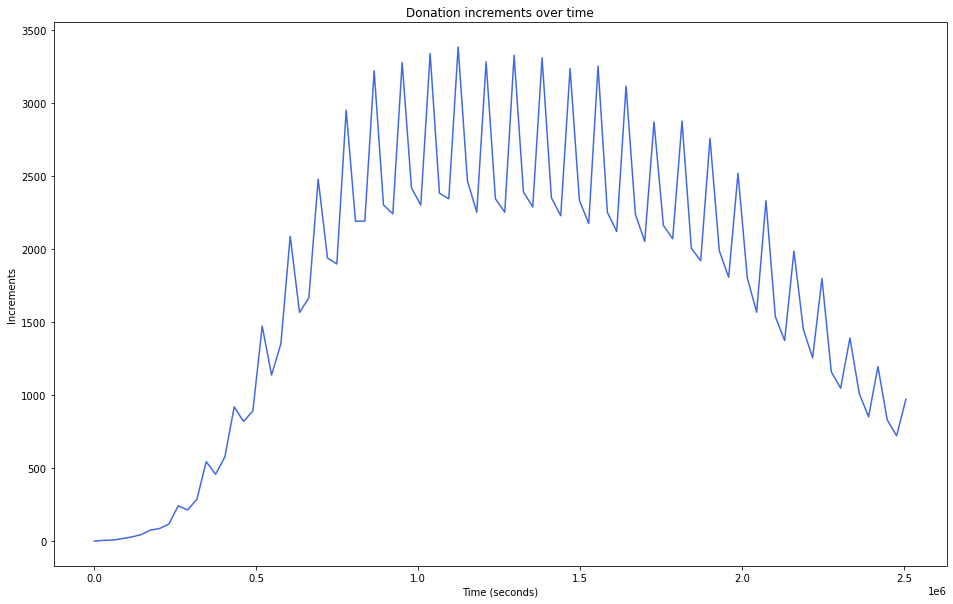

In [3]:
count = [0]
for j in range(num_bins):
    first =df[(j*s<= df['t']) & (df['t']  <= (j+1)*s)]['N(t)'].iloc[0]
    last = df[(j*s<= df['t']) & (df['t']  <= (j+1)*s)]['N(t)'].iloc[-1]
    count.append(last-first)
    
    
rango = range(0,s_range, s)

plt.figure(figsize=(16,10))
plt.xlabel('Time (seconds)')
plt.ylabel('Increments');
plt.title('Donation increments over time')
plt.plot(rango, count, color='royalblue');

The histogram below shows the distribution of donation hours and support the periodicity feature.

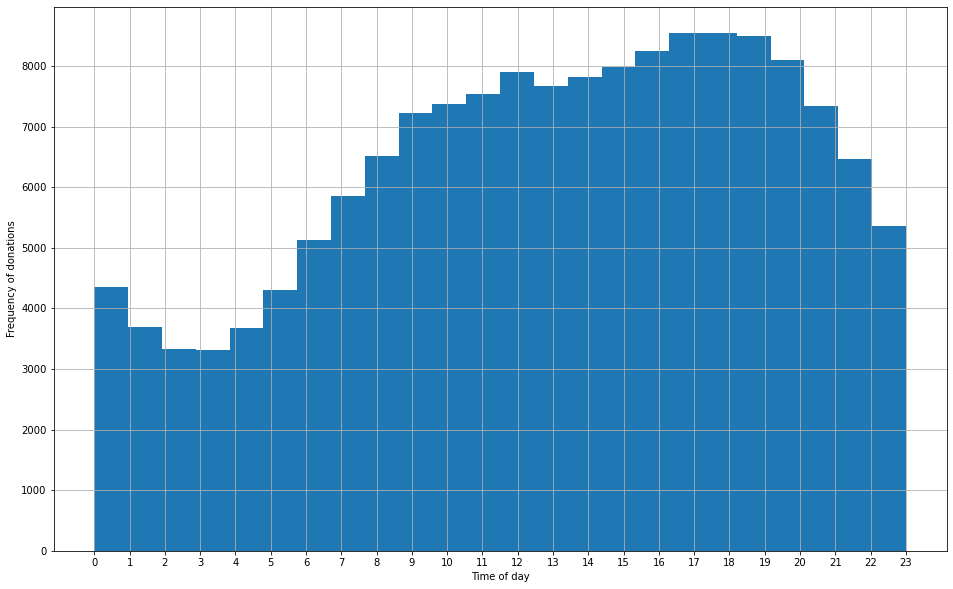

In [4]:
plt.figure(figsize=(16,10))
plt.xticks(range(24))
plt.xlabel('Time of day')
plt.ylabel('Frequency of donations')
df['Time'].dt.hour.hist(bins=24);

## 2. Countries and GDPs

If the data is real, a country's average donation is related to some measure of its wealth. I used GDP figures from 2012 on the World Bank website to analyze the relationship between a country's average donation and its GDP. 

It's reasonable to expect small average donations originating from countries with small GDP and larger average donations from wealthier countries. The following graph illustrates this natural tendency.

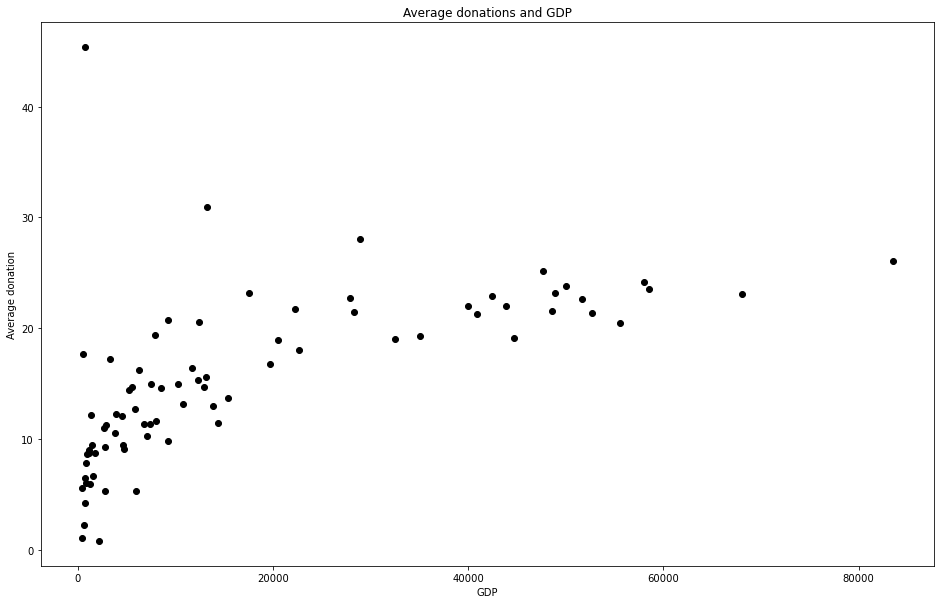

In [5]:
countries_mean_donation = df_gdp.groupby('Country')['Amount'].mean()
countries_gdp = df_gdp.groupby('Country')['GDP'].mean()
plt.figure(figsize=(16,10))
plt.xlabel('GDP')
plt.ylabel('Average donation')
plt.title('Average donations and GDP')
plt.scatter(countries_gdp, countries_mean_donation, color='black');

Note that there seem to be at least two outliers in this graph. This feature is explored below in the Task 2 discussion.

## 3. Rate of donations

The following graph shows the rate of number donations per second $$\frac{N(t)}{t}$$ 

The graph illustrates how during September 2012, the number of donations increased and reached a maximum sometime during the 3rd week. This behavior points to the data not being faked as it is reasonable to expect that the donations became more frequent as the project gained more popularity and eventually decreased.

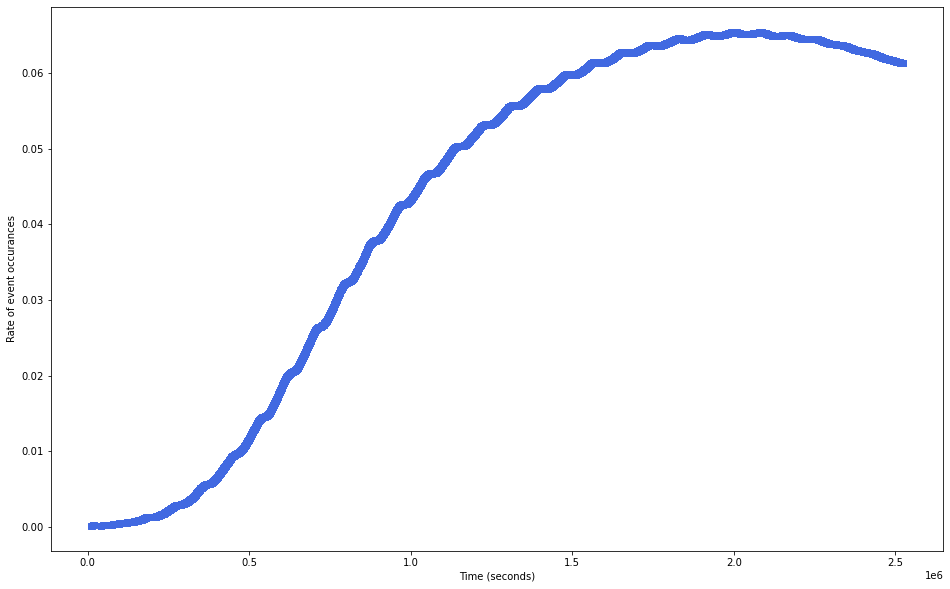

In [6]:
x = df['t']
y = df['N(t)']/x
plt.figure(figsize=(16,10))
plt.scatter(x, y, marker =",", color='royalblue')
plt.xlabel('Time (seconds)')
plt.ylabel('Rate of event occurances');

## 4. Exponential distribution of donations waiting time

The time between donations seems to follow an exponential distribution. This distribution hints that the data is not fake as the underlying process should generate interarrival times with this characteristic.

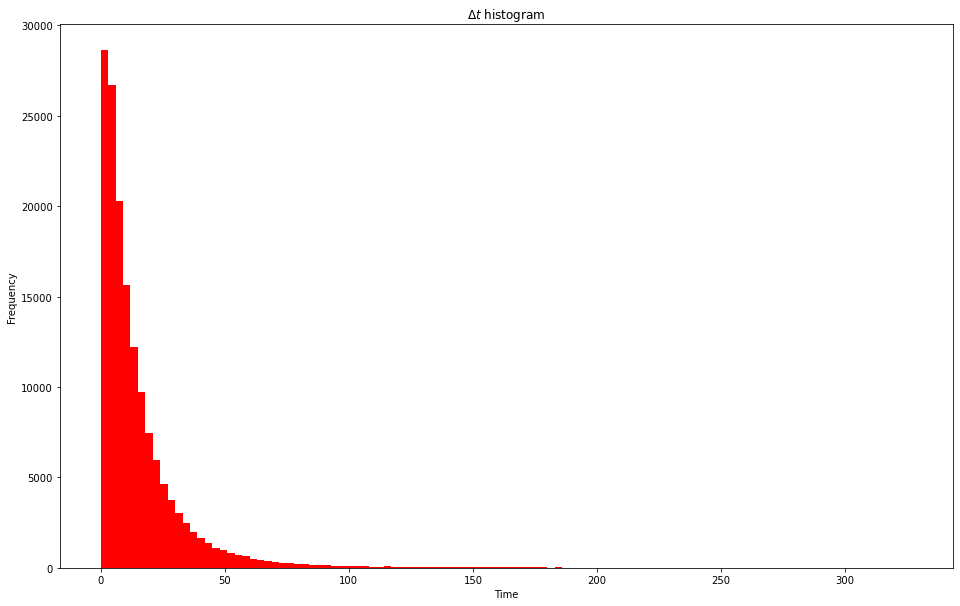

In [7]:
bins = np.linspace(0, 327, 110)
time_delta = df['Time Delta'] 
data_entries, bins = np.histogram(time_delta, bins=bins)

binscenters = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)])
plt.figure(figsize=(16,10))
plt.bar(binscenters, data_entries, width=bins[1] - bins[0], color='red');
plt.title('$\Delta t$ histogram')
plt.xlabel('Time')
plt.ylabel('Frequency');


# Task 2: Features of faked data

## 1. Distribution of leading digits of donations and Benford's Law

The donation amount distribution expands across five orders of magnitude.

In [8]:
df.Amount.describe()

count    154733.000000
mean         22.160972
std          39.453018
min           0.090000
25%           5.000000
50%          10.000000
75%          25.000000
max        2500.000000
Name: Amount, dtype: float64

Therefore, according to Benford's law, the probability $P(D)$ that the first (decimal) digit in the amount variable is $D$ should be given by a logarithmic distribution.

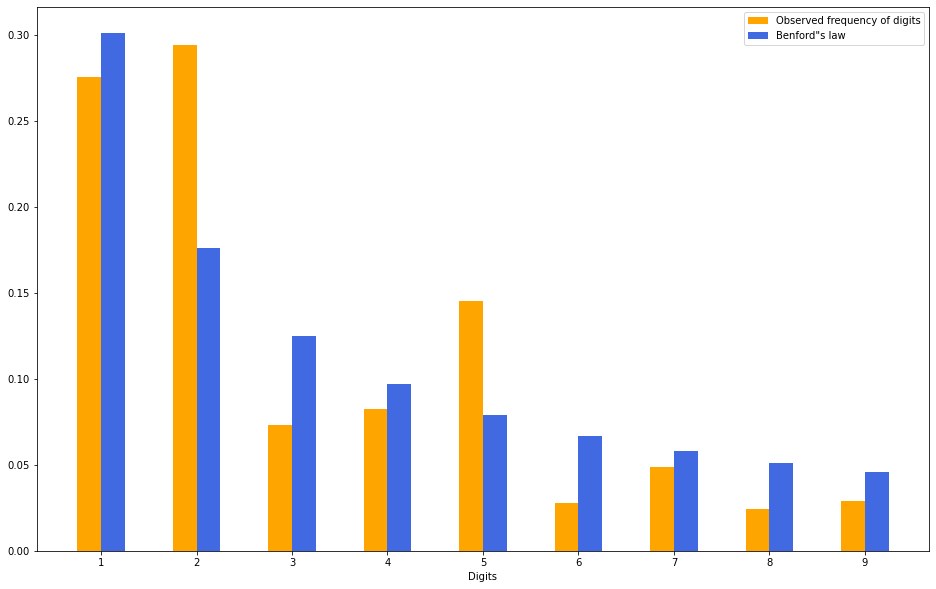

In [9]:
bar_w = 0.25
benford = [0.30103, 0.176091, 0.124939, 0.09691, 0.0791812, 0.0669468, 0.0579919, 0.0511525, 0.0457575]
rel_frequency_of_digits = (df.groupby('Amount leading digit')['Time'].count()/154733).to_numpy()

x1 = np.arange(9)
x2 = [x + bar_w for x in x1]

plt.figure(figsize=(16,10))
plt.bar(x1, rel_frequency_of_digits, color = 'orange', width = bar_w, label = 'Observed frequency of digits')
plt.bar(x2, benford, color = 'royalblue', width = bar_w, label = 'Benford"s law')

plt.xlabel('Digits')
plt.xticks([r + bar_w/2 for r in range(9)],['1', '2', '3', '4', '5', '6', '7', '8', '9'])
plt.legend()
plt.show;

The clear difference between these two distributions is a feature that suggests the data is faked.

Finally, to determine whether there is a statistically significant difference between the expected frequencies and the observed frequencies we perform $\chi^2$ test.

In [10]:
from scipy.stats import chisquare
benford_freq = np.array(benford)*154733
frequency_of_digits = (df.groupby('Amount leading digit')['Time'].count()).to_numpy()
chisquare(frequency_of_digits, benford_freq)

Power_divergenceResult(statistic=31735.528373162713, pvalue=0.0)

## 2. Outlier country donations

As noted in the GDP discussion above, some countries are outliers in terms of their average donations. For example, Rwanda is the country with the highest mean of donations. This value is a suspicious feature of the data given Rwanda's GDP. 

In [11]:
df.groupby('Country')['Amount'].mean().sort_values(ascending = False)

Country
Rwanda         45.413333
Croatia        30.983837
Cyprus         28.072093
Switzerland    26.088693
Finland        25.197586
                 ...    
Uganda          4.192857
Gambia          2.855000
Liberia         2.250000
Ethiopia        1.050000
Honduras        0.760000
Name: Amount, Length: 86, dtype: float64

In [12]:
df_gdp[df_gdp['Country'] == 'Rwanda']

,Time,City,Region,Country,Amount,Amount leading digit,Time Delta,t,N(t),GDP
13452,2012-09-09 06:27:52,Kigali,KigaliCity,Rwanda,4.57,4,12.0,645616.0,13452,728.697297
74629,2012-09-17 06:42:37,Kigali,KigaliCity,Rwanda,3.66,3,2.0,1337701.0,74629,728.697297
139669,2012-09-26 16:00:11,Kigali,KigaliCity,Rwanda,128.01,1,12.0,2148755.0,139669,728.697297


The donations from Croatia also hinted at the fakeness of the data.

In [13]:
df_gdp[df_gdp['Country'] == 'Croatia'].describe()

,Amount,Amount leading digit,Time Delta,t,N(t),GDP
count,86.000000,86.000000,86.000000,8.600000e+01,86.000000,8.600000e+01
mean,30.983837,3.255814,16.709302,1.406433e+06,80234.813953,1.323810e+04
std,71.761657,2.006965,22.008483,5.246861e+05,43368.047776,1.463726e-11
min,0.510000,1.000000,0.000000,2.291810e+05,382.000000,1.323810e+04
25%,4.050000,2.000000,2.250000,1.027889e+06,46348.000000,1.323810e+04
50%,10.130000,3.000000,11.000000,1.473586e+06,87672.000000,1.323810e+04
75%,20.260000,4.000000,21.000000,1.817238e+06,117077.000000,1.323810e+04
max,506.580000,9.000000,132.000000,2.372076e+06,149827.000000,1.323810e+04
